###### Imports

In [1]:
import numpy as np
from core.ml.generativeTf import RBM, variationalAutoencoderTfiationalAutoencoderTf, VQVAE

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_datasets as tfds

tfk = tf.keras
tfkl = tf.keras.layers
tfd = tfp.distributions
tfpl = tfp.layers

import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow'

###### Data

In [3]:
ds, ds_info = tfds.load('mnist', with_info=True)
input_shape = ds_info.features['image'].shape
len(ds['train']), len(ds['test']), input_shape

(60000, 10000, (28, 28, 1))

In [4]:
# binarize the images
def preprocess_binarize(image):
    return tf.where((tf.cast(image, tf.float32) / 255.) > .5, 1.0, 0.0)

In [5]:
def plot_latent_space(decoder, n=30, figsize=15, scale=1.0):
    # display a n*n 2D manifold of digits
    digit_size = 28
    
    figure = np.zeros((digit_size * n, digit_size * n))
    
    # linearly spaced coordinates corresponding in the 2D latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size,
                   j * digit_size : (j + 1) * digit_size] = digit

    plt.figure(figsize=(figsize, figsize))
    
    # set axis ticks corresponding to latent values
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    plt.xticks(pixel_range, np.round(grid_x, 1))
    plt.yticks(pixel_range, np.round(grid_y, 1))

    # axis labels
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

###### RBM

In [37]:
hid_dim = 64
epochs = 50
batch_size = 128

In [38]:
dataset = tf.data.Dataset.from_tensor_slices(x_train.reshape((-1, 28 * 28)).astype('float32'))
dataset = dataset.shuffle(buffer_size=x_train.shape[0], reshuffle_each_iteration=True).batch(batch_size)

In [39]:
rbm = RBM(n_vis=28 * 28, n_hid=hid_dim)
rbm.compile(keras.optimizers.Adam(learning_rate=0.0001))
rbm.fit(dataset, epochs=epochs)

Epoch 1/50
469/469 [==============================] - 2s 4ms/step - recon_loss: 0.1211 - total_loss: -36.0959 - pos_loss: -77.7386 - neg_loss: -41.6427
Epoch 2/50
469/469 [==============================] - 2s 4ms/step - recon_loss: 0.0820 - total_loss: -48.3725 - pos_loss: -89.0852 - neg_loss: -40.7128
Epoch 3/50
469/469 [==============================] - 2s 4ms/step - recon_loss: 0.0688 - total_loss: -46.2405 - pos_loss: -88.2525 - neg_loss: -42.0121
Epoch 4/50
469/469 [==============================] - 2s 4ms/step - recon_loss: 0.0620 - total_loss: -42.3996 - pos_loss: -83.9549 - neg_loss: -41.5553
Epoch 5/50
469/469 [==============================] - 2s 4ms/step - recon_loss: 0.0574 - total_loss: -39.5130 - pos_loss: -80.2804 - neg_loss: -40.7674
Epoch 6/50
469/469 [==============================] - 2s 4ms/step - recon_loss: 0.0537 - total_loss: -37.5522 - pos_loss: -77.7112 - neg_loss: -40.1590
Epoch 7/50
469/469 [==============================] - 2s 4ms/step - recon_loss: 0.0512 -

In [40]:
from PIL import Image
    
for i in np.random.choice(np.arange(x_test.shape[0]), 5, replace=False):
    x = x_test[i]
    x_tensor = tf.convert_to_tensor(x.reshape(1, 28 * 28), dtype=tf.float32)
    x_reconstructed_tensor = rbm.reconstruct(x_tensor)
    x_reconstructed = x_reconstructed_tensor.numpy().reshape(28, 28)

    Image.fromarray((x * 255).astype(np.uint8)).save(f'./results/mnist_rbm/{i}_original.png')
    Image.fromarray((x_reconstructed * 255).astype(np.uint8)).save(f'./results/mnist_rbm/{i}_reconstructed.png')

###### VAE

In [6]:
hid_dim = 2
epochs = 50
batch_size = 128

train_ds = ds['train'].map(lambda x: preprocess_binarize(x['image'])).shuffle(buffer_size=ds_info.splits['train'].num_examples).batch(batch_size)

In [8]:
encoder = tf.keras.Sequential([tfkl.InputLayer(input_shape = input_shape),
                               tfkl.Conv2D(filters=32, kernel_size=3, strides=2, activation='relu', padding='same'),
                               tfkl.Conv2D(filters=64, kernel_size=3, strides=2, activation='relu', padding='same'),
                               tfkl.Flatten(),
                               tfkl.Dense(hid_dim + hid_dim), # output mean and log variance (for numerical stability); No activation
                              ], name='encoder')
    
decoder = tf.keras.Sequential([tfkl.InputLayer(input_shape=(hid_dim,)),
                               tfkl.Dense(units=7 * 7 * 32, activation=tf.nn.relu),
                               tfkl.Reshape(target_shape=(7, 7, 32)),
                               tfkl.Conv2DTranspose(filters=64, kernel_size=3, strides=2, activation='relu', padding='same'),
                               tfkl.Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu', padding='same'),
                               tfkl.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid'),
                              ], name="decoder")

# define the VAE from an encoder and a decoder
vae = variationalAutoencoderTf(encoder, decoder)
vae.compile(optimizer=tfk.optimizers.Adam())

In [10]:
vae.encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense_2 (Dense)             (None, 4)                 12548     
                                                                 
Total params: 31,364
Trainable params: 31,364
Non-trainable params: 0
_________________________________________________________________


In [11]:
vae.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1568)              4704      
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 32)          0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 14, 14, 64)       18496     
 ranspose)                                                       
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 28, 28, 1)        289       
 ranspose)                                                       
                                                           

In [ ]:
# train
hist = vae.fit(train_ds, epochs=epochs)

Epoch 1/50


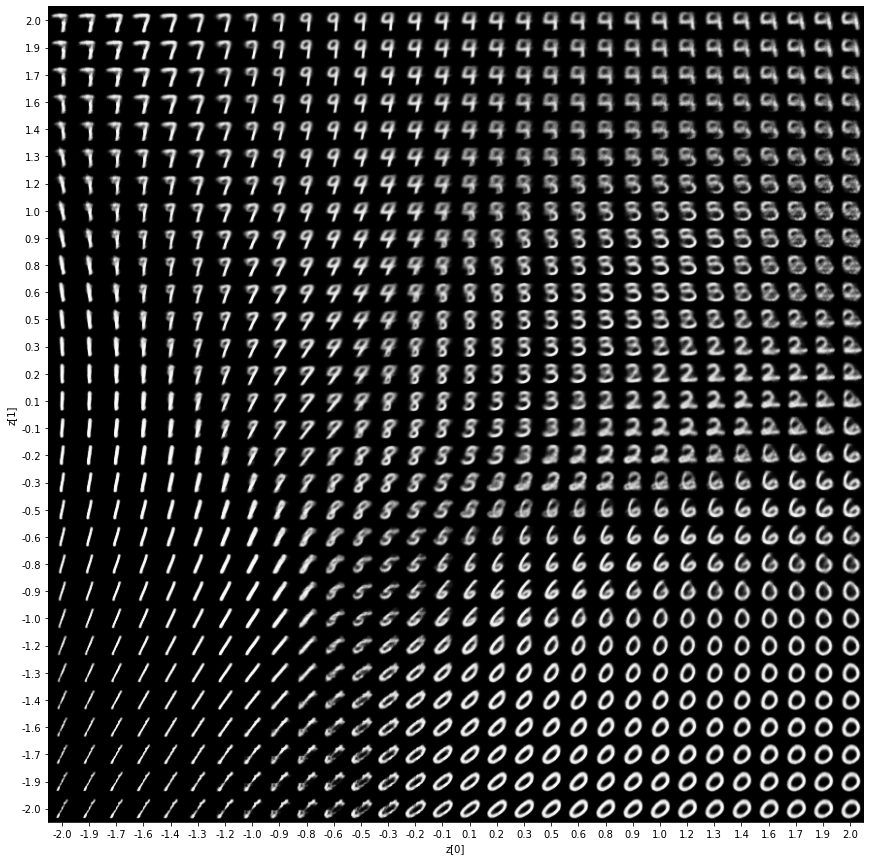

In [13]:
plot_latent_space(decoder, scale=2.0, n=30)

###### β-VAE

In [9]:
hid_dim = 2
epochs = 50
batch_size = 128
beta = 2.0

train_ds = ds['train'].map(lambda x: preprocess_binarize(x['image'])).shuffle(buffer_size=ds_info.splits['train'].num_examples).batch(batch_size)

In [16]:
encoder = tf.keras.Sequential([tfkl.InputLayer(input_shape=input_shape),
                               tfkl.Conv2D(filters=32, kernel_size=3, strides=2, activation='relu', padding='same'),
                               tfkl.Conv2D(filters=64, kernel_size=3, strides=2, activation='relu', padding='same'),
                               tfkl.Flatten(),
                               tfkl.Dense(hid_dim + hid_dim), # output mean and log variance (for numerical stability); No activation
                              ], name='encoder')
    
decoder = tf.keras.Sequential([tfkl.InputLayer(input_shape=(hid_dim,)),
                               tfkl.Dense(units=7 * 7 * 32, activation=tf.nn.relu),
                               tfkl.Reshape(target_shape=(7, 7, 32)),
                               tfkl.Conv2DTranspose(filters=64, kernel_size=3, strides=2, activation='relu', padding='same'),
                               tfkl.Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu', padding='same'),
                               tfkl.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid'),
                              ], name="decoder")

# define the VAE from an encoder and a decoder
beta_vae = VAE(encoder, decoder, beta=beta)
beta_vae.compile(optimizer=tfk.optimizers.Adam())

# train
beta_vae.fit(train_ds, epochs=epochs)

Epoch 1/50
469/469 [==============================] - 8s 13ms/step - total_loss: 210.6235 - recon_loss: 203.3223 - kl_loss: 3.6506
Epoch 2/50
469/469 [==============================] - 7s 13ms/step - total_loss: 172.4674 - recon_loss: 162.6870 - kl_loss: 4.8902
Epoch 3/50
469/469 [==============================] - 7s 13ms/step - total_loss: 166.2935 - recon_loss: 155.7030 - kl_loss: 5.2953
Epoch 4/50
469/469 [==============================] - 7s 13ms/step - total_loss: 163.4880 - recon_loss: 152.4474 - kl_loss: 5.5202
Epoch 5/50
469/469 [==============================] - 7s 13ms/step - total_loss: 161.7410 - recon_loss: 150.4591 - kl_loss: 5.6410
Epoch 6/50
469/469 [==============================] - 7s 13ms/step - total_loss: 160.6346 - recon_loss: 149.1539 - kl_loss: 5.7404
Epoch 7/50
469/469 [==============================] - 7s 13ms/step - total_loss: 159.7218 - recon_loss: 148.0826 - kl_loss: 5.8196
Epoch 8/50
469/469 [==============================] - 7s 13ms/step - total_loss: 15

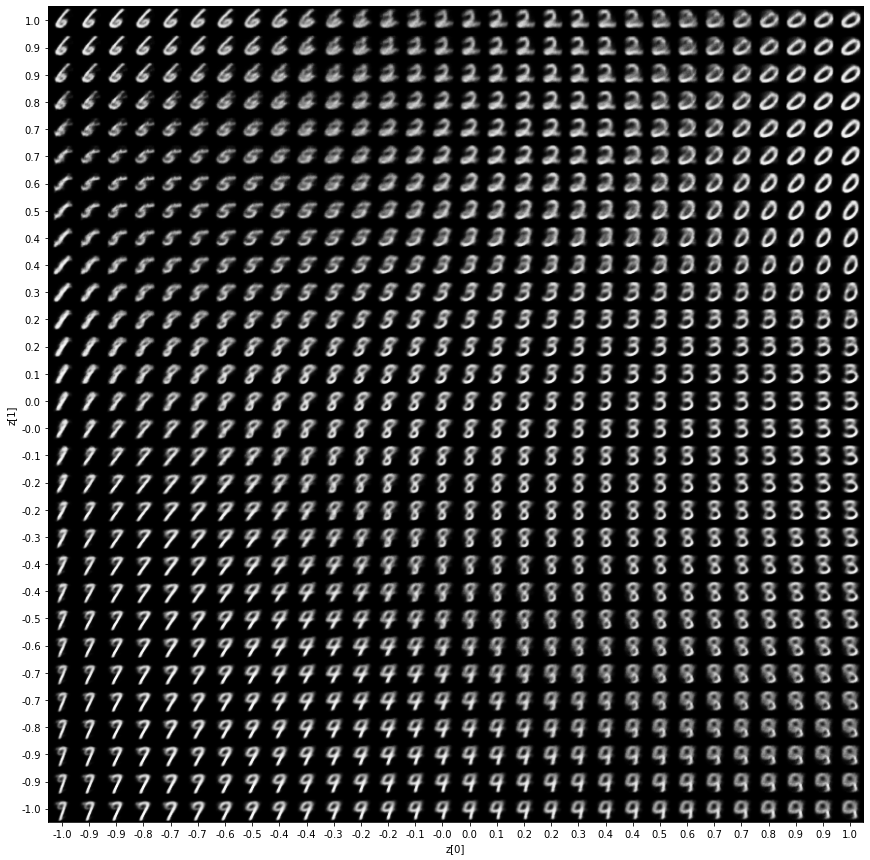

In [18]:
plot_latent_space(beta_vae.decoder)

###### VQ-VAE

In [32]:
latent_dim = 16
num_embeddings = 128
beta = 0.25
data_variance = np.var(x_train)
epochs = 50
batch_size = 128

In [33]:
dataset = tf.data.Dataset.from_tensor_slices(x_train.reshape((-1, 28, 28, 1)).astype('float32'))
dataset = dataset.shuffle(buffer_size=x_train.shape[0], reshuffle_each_iteration=True).batch(batch_size)

In [34]:
encoder = tf.keras.Sequential([layers.InputLayer(input_shape=(28, 28, 1)),
                               layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2),
                                             activation='relu', padding='same'),
                               layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2),
                                             activation='relu', padding='same'),
                               layers.Conv2D(latent_dim, 1, padding="same")
                              ], name='encoder')

decoder = tf.keras.Sequential([layers.InputLayer(input_shape=encoder.output.shape[1:]),
                               layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2,
                                                      padding='same', activation='relu'),
                               layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2,
                                                      padding='same', activation='relu'),
                               layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1,
                                                      padding='same'),
                              ], name="decoder")

vqvae = VQVAE(encoder, decoder, latent_dim, num_embeddings, beta, data_variance)
vqvae.compile(optimizer=keras.optimizers.Adam())
vqvae.fit(dataset, epochs=epochs)

Epoch 1/50
469/469 [==============================] - 6s 13ms/step - total_loss: 12.1554 - recon_loss: 0.6017 - code_loss: 16.7398 - comm_loss: 16.7398 - vq_loss: 11.7958
Epoch 2/50
469/469 [==============================] - 6s 12ms/step - total_loss: 0.5857 - recon_loss: 0.1822 - code_loss: 0.3814 - comm_loss: 0.3814 - vq_loss: 0.4139
Epoch 3/50
469/469 [==============================] - 6s 13ms/step - total_loss: 0.4303 - recon_loss: 0.1487 - code_loss: 0.2447 - comm_loss: 0.2447 - vq_loss: 0.2887
Epoch 4/50
469/469 [==============================] - 6s 13ms/step - total_loss: 0.2838 - recon_loss: 0.1190 - code_loss: 0.1494 - comm_loss: 0.1494 - vq_loss: 0.1695
Epoch 5/50
469/469 [==============================] - 6s 13ms/step - total_loss: 0.2409 - recon_loss: 0.1034 - code_loss: 0.1141 - comm_loss: 0.1141 - vq_loss: 0.1400
Epoch 6/50
469/469 [==============================] - 6s 13ms/step - total_loss: 0.2215 - recon_loss: 0.0929 - code_loss: 0.1066 - comm_loss: 0.1066 - vq_loss: 0

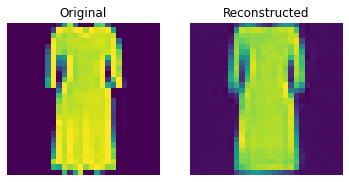

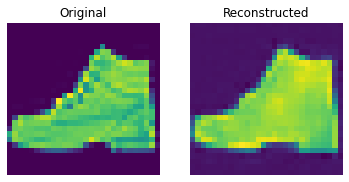

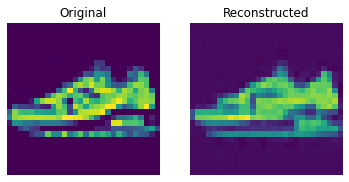

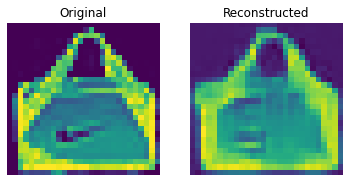

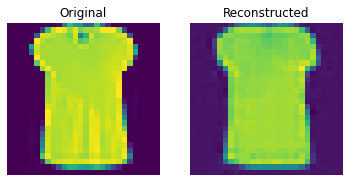

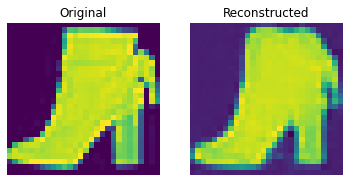

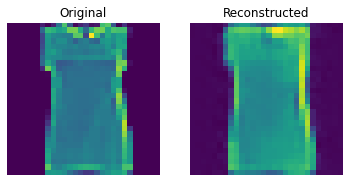

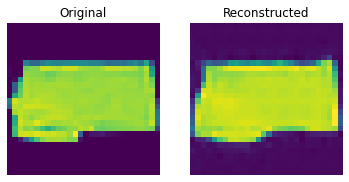

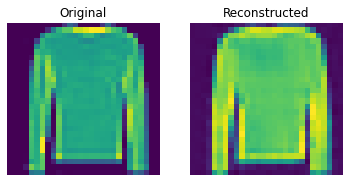

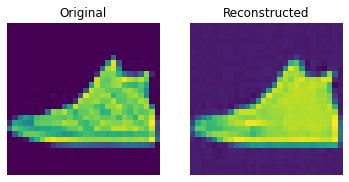

In [35]:
def show_subplot(original, reconstructed):
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze())
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed.squeeze())
    plt.title("Reconstructed")
    plt.axis("off")

    plt.show()

idx = np.random.choice(len(x_test), 10)
test_images = x_test[idx]
reconstructions_test = vqvae.reconstruct(test_images).numpy()

for test_image, reconstructed_image in zip(test_images, reconstructions_test):
    show_subplot(test_image, reconstructed_image)

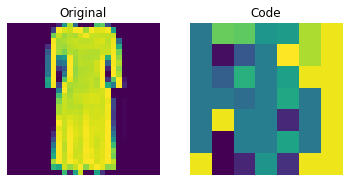

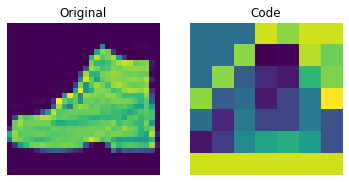

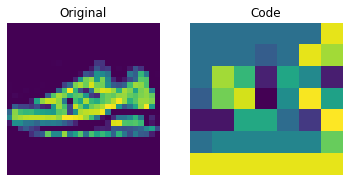

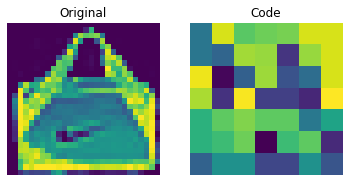

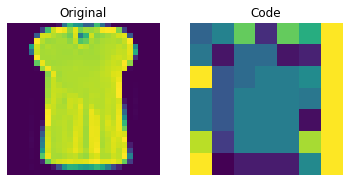

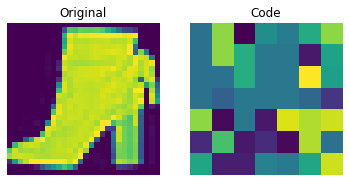

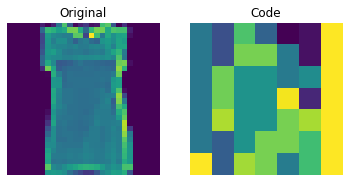

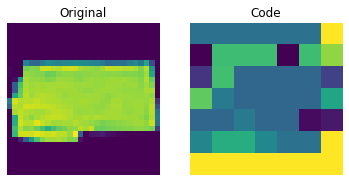

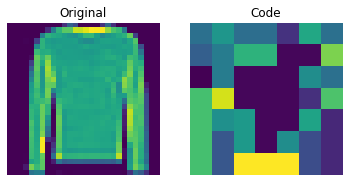

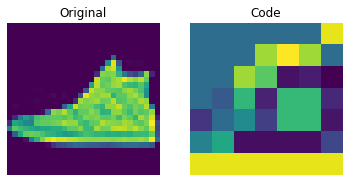

In [36]:
# visualizing the codes
encoder = vqvae.get_layer("encoder")
quantizer = vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(test_images)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])

for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].squeeze() + 0.5)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")
    plt.show()

###### TFP VAE

In [19]:
if tf.test.gpu_device_name() != '/device:GPU:0':
    print('WARNING: GPU device not found.')
else:
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


In [57]:
hid_dim = 2 # encoded_size = 16
epochs = 50
batch_size = 128
base_depth = 32

In [58]:
def binarize_random(sample):
    image = tf.cast(sample['image'], tf.float32) / 255.  # Scale to unit interval.
    image = image < tf.random.uniform(tf.shape(image))   # Randomly binarize.
    return image, image

def display_imgs(x, y=None):
    if not isinstance(x, (np.ndarray, np.generic)):
        x = np.array(x)
        
    plt.ioff()
    n = x.shape[0]
    fig, axs = plt.subplots(1, n, figsize=(n, 1))
    if y is not None:
        fig.suptitle(np.argmax(y, axis=1))
        
    for i in range(n):
        axs.flat[i].imshow(x[i].squeeze(), interpolation='none', cmap='gray')
        axs.flat[i].axis('off')
        
    plt.show()
    plt.close()
    plt.ion()

train_ds = (ds['train'].map(binarize_random).batch(batch_size).prefetch(tf.data.AUTOTUNE).shuffle(buffer_size=1000))
eval_ds = (ds['test'].map(binarize_random).batch(batch_size).prefetch(tf.data.AUTOTUNE))

# prior distribution for latent space
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(hid_dim), scale=1), reinterpreted_batch_ndims=1)

In [63]:
# the encoder network, the output is a normal distribution - not a tensor!
# note the regularizer - this adds a KL divergence to the model loss
encoder = tf.keras.Sequential([tfkl.InputLayer(input_shape = input_shape),
                               tfkl.Conv2D(filters=32, kernel_size=3, strides=2, activation='relu', padding='same'),
                               tfkl.Conv2D(filters=64, kernel_size=3, strides=2, activation='relu', padding='same'),
                               tfkl.Flatten(),
                               tfkl.Dense(tfpl.IndependentNormal.params_size(hid_dim), activation=None),
                               tfpl.IndependentNormal(hid_dim, activity_regularizer=tfpl.KLDivergenceRegularizer(prior))
                              ], name='encoder')

# the decoder outputs a tensor
decoder = tf.keras.Sequential([tfkl.InputLayer(input_shape=(hid_dim,)),
                               tfkl.Dense(units=7 * 7 * 32, activation=tf.nn.relu),
                               tfkl.Reshape(target_shape=(7, 7, 32)),
                               tfkl.Conv2DTranspose(filters=64, kernel_size=3, strides=2, activation='relu', padding='same'),
                               tfkl.Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu', padding='same'),
                               tfkl.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid'),
                              ], name="decoder")

# define the model and compile
vae = tfk.Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs[0]))
vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), loss=tfk.losses.binary_crossentropy)

_ = vae.fit(train_ds, epochs=epochs, validation_data=eval_ds)

Epoch 1/50
469/469 [==============================] - 12s 16ms/step - loss: 0.3045 - val_loss: 0.2653
Epoch 2/50
469/469 [==============================] - 10s 15ms/step - loss: 0.2689 - val_loss: 0.2679
Epoch 3/50
469/469 [==============================] - 11s 15ms/step - loss: 0.2686 - val_loss: 0.2630
Epoch 4/50
469/469 [==============================] - 11s 15ms/step - loss: 0.2663 - val_loss: 0.2664
Epoch 5/50
469/469 [==============================] - 11s 15ms/step - loss: 0.2661 - val_loss: 0.2680
Epoch 6/50
469/469 [==============================] - 11s 15ms/step - loss: 0.2657 - val_loss: 0.2710
Epoch 7/50
469/469 [==============================] - 10s 15ms/step - loss: 0.2660 - val_loss: 0.2705
Epoch 8/50
469/469 [==============================] - 10s 15ms/step - loss: 0.2649 - val_loss: 0.2634
Epoch 9/50
469/469 [==============================] - 10s 15ms/step - loss: 0.2650 - val_loss: 0.2667
Epoch 10/50
469/469 [==============================] - 10s 15ms/step - loss: 0.264

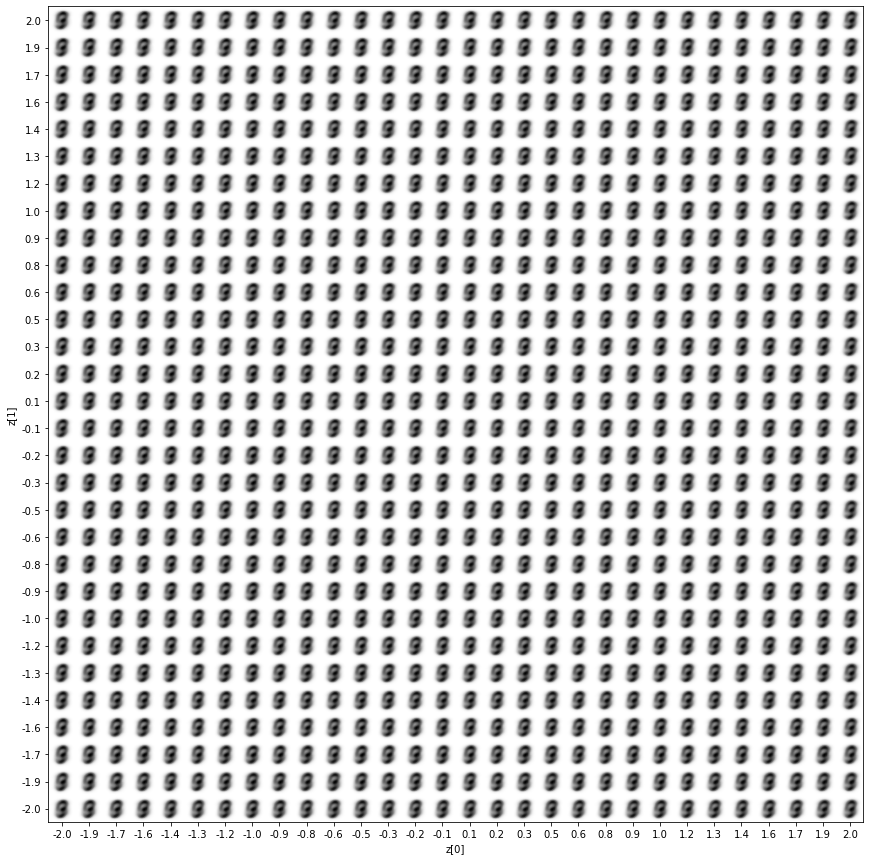

In [64]:
plot_latent_space(decoder, scale=2.0, n=30)

In [60]:
# encoder is identical to previous one - the output is a normal distribution and a regularizer for the KL div
encoder = tf.keras.Sequential([tfkl.InputLayer(input_shape = input_shape),
                               tfkl.Conv2D(filters=32, kernel_size=3, strides=2, activation='relu', padding='same'),
                               tfkl.Conv2D(filters=64, kernel_size=3, strides=2, activation='relu', padding='same'),
                               tfkl.Flatten(),
                               tfkl.Dense(tfpl.IndependentNormal.params_size(hid_dim), activation=None),
                               tfpl.IndependentNormal(hid_dim, activity_regularizer=tfpl.KLDivergenceRegularizer(prior))
                              ], name='encoder')

# the decoder now outputs a Bernoulli distribution
# the final layer now has no activation and we use those as logits for the Bernoulli dist
decoder = tf.keras.Sequential([tfkl.InputLayer(input_shape=(hid_dim,)),
                               tfkl.Dense(units=7 * 7 * 32, activation='relu'),
                               tfkl.Reshape(target_shape=(7, 7, 32)),
                               tfkl.Conv2DTranspose(filters=64, kernel_size=3, strides=2, activation='relu', padding='same'),
                               tfkl.Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu', padding='same'),
                               tfkl.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', activation=None),
                               tfkl.Flatten(),
                               tfpl.IndependentBernoulli(input_shape, convert_to_tensor_fn=tfd.Bernoulli.logits)
                              ], name="decoder")

# as the output of the network is a distribution we need to define the loss
negloglik = lambda x, rv_x: -rv_x.log_prob(x)

# define the model and compile
vae = tfk.Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs[0]))
vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), loss=negloglik)

_ = vae.fit(train_ds, epochs=epochs, validation_data=eval_ds)

Epoch 1/50
469/469 [==============================] - 12s 17ms/step - loss: 204.0650 - val_loss: 178.2231
Epoch 2/50
469/469 [==============================] - 10s 15ms/step - loss: 173.8955 - val_loss: 170.4402
Epoch 3/50
469/469 [==============================] - 11s 15ms/step - loss: 169.1991 - val_loss: 168.0112
Epoch 4/50
469/469 [==============================] - 11s 16ms/step - loss: 166.9483 - val_loss: 166.1514
Epoch 5/50
469/469 [==============================] - 11s 15ms/step - loss: 165.7653 - val_loss: 164.8539
Epoch 6/50
469/469 [==============================] - 10s 15ms/step - loss: 164.8573 - val_loss: 164.9765
Epoch 7/50
469/469 [==============================] - 10s 15ms/step - loss: 164.2408 - val_loss: 163.7975
Epoch 8/50
469/469 [==============================] - 10s 15ms/step - loss: 163.7492 - val_loss: 164.0930
Epoch 9/50
469/469 [==============================] - 10s 16ms/step - loss: 163.4374 - val_loss: 162.9042
Epoch 10/50
469/469 [=========================

Originals:


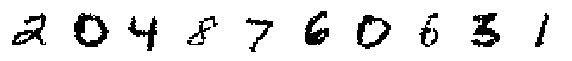

Decoded Random Samples:


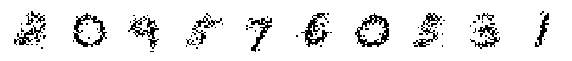

Decoded Modes:


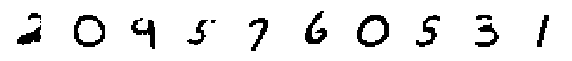

Decoded Means:


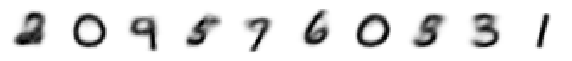

In [62]:
# We'll just examine ten random digits.
x = next(iter(eval_ds))[0][:10]
xhat = vae(x)
assert isinstance(xhat, tfd.Distribution)

print('Originals:')
display_imgs(x)

print('Decoded Random Samples:')
display_imgs(xhat.sample())

print('Decoded Modes:')
display_imgs(xhat.mode())

print('Decoded Means:')
display_imgs(xhat.mean())

In [121]:
encoder = tfk.Sequential([tfkl.InputLayer(input_shape=input_shape),
                          tfkl.Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
                          tfkl.Conv2D(base_depth, 5, strides=1, padding='same', activation=tf.nn.leaky_relu),
                          tfkl.Conv2D(base_depth, 5, strides=2, padding='same', activation=tf.nn.leaky_relu),
                          tfkl.Conv2D(2 * base_depth, 5, strides=1, padding='same', activation=tf.nn.leaky_relu),
                          tfkl.Conv2D(2 * base_depth, 5, strides=2, padding='same', activation=tf.nn.leaky_relu),
                          tfkl.Conv2D(4 * hid_dim, 7, strides=1, padding='valid', activation=tf.nn.leaky_relu),
                          tfkl.Flatten(),
                          tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(hid_dim), activation=None),
                          tfpl.MultivariateNormalTriL(hid_dim, activity_regularizer=tfpl.KLDivergenceRegularizer(prior))])

decoder = tfk.Sequential([tfkl.InputLayer(input_shape=[hid_dim]),
                          tfkl.Reshape([1, 1, hid_dim]),
                          tfkl.Conv2DTranspose(2 * base_depth, 7, strides=1, padding='valid', activation=tf.nn.leaky_relu),
                          tfkl.Conv2DTranspose(2 * base_depth, 5, strides=1, padding='same', activation=tf.nn.leaky_relu),
                          tfkl.Conv2DTranspose(2 * base_depth, 5, strides=2, padding='same', activation=tf.nn.leaky_relu),
                          tfkl.Conv2DTranspose(base_depth, 5, strides=1, padding='same', activation=tf.nn.leaky_relu),
                          tfkl.Conv2DTranspose(base_depth, 5, strides=2, padding='same', activation=tf.nn.leaky_relu),
                          tfkl.Conv2DTranspose(base_depth, 5, strides=1, padding='same', activation=tf.nn.leaky_relu),
                          tfkl.Conv2D(filters=1, kernel_size=5, strides=1, padding='same', activation=None),
                          tfkl.Flatten(),
                          tfpl.IndependentBernoulli(input_shape, tfd.Bernoulli.logits)])

vae = tfk.Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs[0]))

In [122]:
negloglik = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), loss=negloglik)

_ = vae.fit(train_dataset, epochs=15, validation_data=eval_dataset)

Epoch 1/15
235/235 [==============================] - 24s 76ms/step - loss: 225.5072 - val_loss: 178.4166
Epoch 2/15
235/235 [==============================] - 21s 74ms/step - loss: 172.7795 - val_loss: 167.7338
Epoch 3/15
235/235 [==============================] - 21s 74ms/step - loss: 165.7504 - val_loss: 162.0936
Epoch 4/15
235/235 [==============================] - 21s 74ms/step - loss: 161.5486 - val_loss: 159.5227
Epoch 5/15
235/235 [==============================] - 21s 74ms/step - loss: 159.1841 - val_loss: 157.4885
Epoch 6/15
235/235 [==============================] - 20s 73ms/step - loss: 157.8513 - val_loss: 156.6942
Epoch 7/15
235/235 [==============================] - 21s 74ms/step - loss: 156.5472 - val_loss: 155.4279
Epoch 8/15
235/235 [==============================] - 21s 74ms/step - loss: 155.5432 - val_loss: 154.5434
Epoch 9/15
235/235 [==============================] - 21s 73ms/step - loss: 154.8761 - val_loss: 155.1756
Epoch 10/15
235/235 [=========================

In [110]:
# We'll just examine ten random digits.
x = next(iter(eval_dataset))[0][:10]
xhat = vae(x)
assert isinstance(xhat, tfd.Distribution)

Originals:


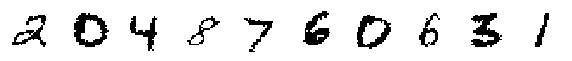

Decoded Random Samples:


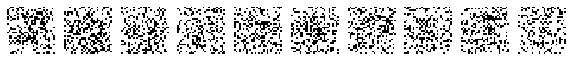

Decoded Modes:


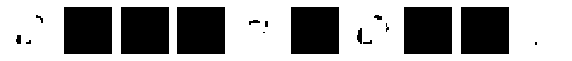

Decoded Means:


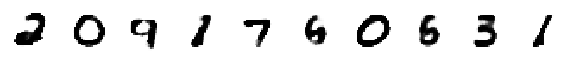

In [112]:
print('Originals:')
display_imgs(x)

print('Decoded Random Samples:')
display_imgs(xhat.sample())

print('Decoded Modes:')
display_imgs(xhat.mode())

print('Decoded Means:')
display_imgs(xhat.mean())

In [17]:
# Now, let's generate ten never-before-seen digits.
z = prior.sample(10)
xtilde = decoder(z)
assert isinstance(xtilde, tfd.Distribution)

Randomly Generated Samples:


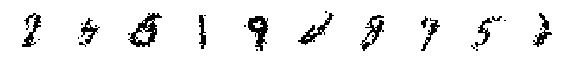

Randomly Generated Modes:


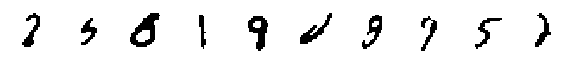

Randomly Generated Means:


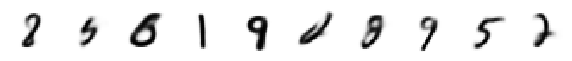

In [18]:
print('Randomly Generated Samples:')
display_imgs(xtilde.sample())

print('Randomly Generated Modes:')
display_imgs(xtilde.mode())

print('Randomly Generated Means:')
display_imgs(xtilde.mean())